In [7]:
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import h5py
from enum import Enum

use_cuda = 1#torch.cuda.is_available()
use_pca = 1
separate_train_videos_to_activity_regions = 1
separate_val_videos_to_activity_regions = 1
monotonic_loss_param = 6
val_id_num = 100
#train_id_num = 1000 #len(train_ids)
n_epochs_for_second_training_phase = 2

In [8]:
def one_hot(i, l):
    a = np.zeros(l, 'uint8')
    a[i] = 1
    return a

In [9]:
data = json.load(open('data/activity_net.v1-3.min.json'))
features_file = h5py.File('data/sub_activitynet_v1-3.c3d.hdf5')
#print(list(data['database'].keys()))
video_id_to_idx = {entry:i for i,entry in enumerate(list(data['database'].keys()))}
video_idx_to_id = {i:entry for i,entry in enumerate(list(data['database'].keys()))}
video_ids = list(data['database'].keys())
train_ids = []
test_ids = []
val_ids = []
for video_id in video_ids:
    if (data['database'][video_id]['subset'] == 'validation'):
        val_ids.append(video_id)
    if (data['database'][video_id]['subset'] == 'training'):
        train_ids.append(video_id)
    if (data['database'][video_id]['subset'] == 'testing'):
        test_ids.append(video_id)    
labels = set()        
for video_id in train_ids:
    labels.add(data['database'][video_id]['annotations'][0]['label'])
label_to_id = {entry:(i+1) for i,entry in enumerate(list(labels))}
label_to_id['none'] = 0
label_num = len(label_to_id)
id_to_label = {(i+1):entry for i,entry in enumerate(list(labels))}
id_to_label[0] = 'none'
#print(label_to_id)
#print(len(train_ids), len(test_ids), len(val_ids))

In [10]:
train_id_to_categories = defaultdict(list)
train_id_to_features = defaultdict(list)
skipped = 0
for video_id in train_ids: #2d array of features for each video. dim0 depends on video len. dim2=500
    
    all_features = features_file['v_' + video_id]['c3d_features']
    duration = data['database'][video_id]['duration']
    frame_num = features_file['v_' + video_id]['c3d_features'].shape[0]
    
    if (separate_train_videos_to_activity_regions==1):
        
        for item in data['database'][video_id]['annotations']:
            start_frame_idx = int((item['segment'][0]/duration)*frame_num)
            end_frame_idx = min(int((item['segment'][1]/duration)*frame_num), frame_num)
            f_frame_num = end_frame_idx - start_frame_idx
            if (f_frame_num==0):
                #print(video_id, " ", label_to_id[item['label']], "f_frame_num = 0")
                skipped += 1
                break
            if (start_frame_idx==0):
                train_id_to_features[video_id].append(all_features[start_frame_idx:end_frame_idx, :])
                train_id_to_categories[video_id].append([label_to_id[item['label']]] * f_frame_num)
            else:
                train_id_to_features[video_id].append(all_features[start_frame_idx-1:end_frame_idx, :])
                train_id_to_categories[video_id].append([label_to_id['none']] + [label_to_id[item['label']]] * f_frame_num)
                
    else:
        
        train_id_to_features[video_id] = all_features       
        train_id_to_categories[video_id] = [label_to_id['none']] * frame_num
        #print(video_id, frame_num)
        for item in data['database'][video_id]['annotations']:
            start_frame_idx = ((item['segment'][0]/duration)*frame_num)
            end_frame_idx = ((item['segment'][1]/duration)*frame_num)
            #print(item['label'], start_frame_idx, end_frame_idx)
            for frame in range(int(start_frame_idx), min(frame_num, int(end_frame_idx))):
                #y = one_hot(label_to_id[item['label']], label_num)
                y = label_to_id[item['label']]
                train_id_to_categories[video_id][frame] = y

In [11]:
print(len(train_id_to_features['6uhLrPgbpUA']), train_id_to_features['6uhLrPgbpUA'][2].shape)
print(skipped)

3 (34, 500)
48


In [12]:
val_id_to_categories = defaultdict(list)
val_id_to_features = defaultdict(list)
val_id_to_activity_regions = defaultdict(list)
skipped = 0
for video_id in val_ids: #2d array of features for each video. dim0 depends on video len. dim2=500
    
    all_features = features_file['v_' + video_id]['c3d_features']
    duration = data['database'][video_id]['duration']
    frame_num = features_file['v_' + video_id]['c3d_features'].shape[0]
    if (separate_val_videos_to_activity_regions==1):
        for item in data['database'][video_id]['annotations']:
            start_frame_idx = int((item['segment'][0]/duration)*frame_num)
            end_frame_idx = min(int((item['segment'][1]/duration)*frame_num), frame_num)
            f_frame_num = end_frame_idx - start_frame_idx
            #print(video_id, f_frame_num)
            if (f_frame_num<4):
                #print(video_id, " ", label_to_id[item['label']], "f_frame_num = ", f_frame_num)
                skipped += 1
                break
            if (start_frame_idx==0):
                val_id_to_features[video_id].append(all_features[start_frame_idx:end_frame_idx, :])
                val_id_to_categories[video_id].append([label_to_id[item['label']]] * f_frame_num)
            else:
                val_id_to_features[video_id].append(all_features[start_frame_idx-1:end_frame_idx, :])
                val_id_to_categories[video_id].append([label_to_id['none']] + [label_to_id[item['label']]] * f_frame_num)
    
    else:
        
        val_id_to_features[video_id] = all_features
        val_id_to_categories[video_id] = [label_to_id['none']] * frame_num
        #print(video_id, frame_num)
        for item in data['database'][video_id]['annotations']:
            start_frame_idx = ((item['segment'][0]/duration)*frame_num)
            end_frame_idx = ((item['segment'][1]/duration)*frame_num)
            val_id_to_activity_regions[video_id].append([int(start_frame_idx), min(frame_num, int(end_frame_idx))])
            #print(item['label'], start_frame_idx, end_frame_idx)
            for frame in range(int(start_frame_idx), min(frame_num, int(end_frame_idx))):
                val_id_to_categories[video_id][frame] = label_to_id[item['label']]

In [7]:
#print(len(train_id_to_categories), len(train_id_to_categories['yUSo_xjyGhM']))
#print(train_id_to_features['yUSo_xjyGhM'].shape)
#print(val_id_to_categories['TOP1Fwili-k'])

In [8]:
#inputs - train_id_to_features
#print(len(train_id_to_features), train_id_to_features['sJFgo9H6zNo'].shape)
#outputs - train_id_to_categories
#print(len(train_id_to_categories), len(train_id_to_categories['sJFgo9H6zNo']), train_id_to_categories['sJFgo9H6zNo'][0].shape)

#print(train_id_to_features['sJFgo9H6zNo'][0,:].squeeze().shape)
#print(train_id_to_categories['sJFgo9H6zNo'][0].squeeze().shape)

In [21]:
class Detector(nn.Module):
    def __init__(self, hidden_size, input_size, output_size, use_soft_max):
        super(Detector, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.use_soft_max = use_soft_max
        if (use_soft_max):
            self.softmax = nn.Softmax(output_size)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.linear(output)
        output = output.view(1,-1)
        if (self.use_soft_max):
            output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [23]:
input_size = 500 if use_pca else 4096
hidden_size = 300 if use_pca else 512
output_size = label_num
learning_rate = 0.001 #consider starting from 0.01 and divide by 10 every N iterations
back_prop_depth = 1000
criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax()

In [11]:
def ResetModel():
    detector = Detector(hidden_size, input_size, output_size, 0).cuda() if use_cuda else Detector(hidden_size, input_size, output_size, 0)
    detector_optimizer = torch.optim.Adam(detector.parameters(), learning_rate)
    return detector, detector_optimizer

decoder, decoder_optimizier = ResetModel()

In [17]:
class LossFuncType(Enum):
    CE = 1
    EARLY = 2   
    MONOTONIC = 3
    EARLY_MONOTONIC = 4
    MIXED = 5

In [18]:
class EarlyLossFunc(torch.nn.Module):
    
    def __init__(self):
        super(EarlyLossFunc,self).__init__()
        
    def forward(self,detector_output, target_variable):
        loss = 0
        T = len(target_variable)
        N = label_num
        loss_arr_scalar = []
        detector_output_after_softmax = softmax(detector_output)
        for di in range(T): #di=0..T-1
            curr_target = Variable(torch.LongTensor([target_variable[di]])) #1x201
            curr_target = curr_target.cuda() if use_cuda else curr_target
            
            
            index = curr_target.data[0]
            loss_per_frame_arr = -((di+1)/(T+1)) * torch.log1p(-detector_output_after_softmax[di])
            loss_per_frame_arr[index] = -torch.log(detector_output_after_softmax[di][index])
            loss_step = loss_per_frame_arr.sum()             
            loss += loss_step
            loss_arr_scalar.append(loss_step.cpu().data[0])
    
        return loss, loss_arr_scalar

class CrossEntropyLossFunc(torch.nn.Module):
    
    def __init__(self):
        super(CrossEntropyLossFunc, self).__init__()
        
    def forward(self,detector_output, target_variable):
        criterion = nn.CrossEntropyLoss()
        loss = 0
        loss_arr_scalar = []
        for di in range(len(target_variable)):
            curr_target = Variable(torch.LongTensor([target_variable[di]])) #1x201
            curr_target = curr_target.cuda() if use_cuda else curr_target         
            loss_step = criterion(detector_output[di].view(1,-1), curr_target)
            loss += loss_step
            loss_arr_scalar.append(loss_step.cpu().data[0])
        
        return loss, loss_arr_scalar
    
class MonotonicLossFunc(torch.nn.Module):
    
    def __init__(self, param):
        super(MonotonicLossFunc, self).__init__()
        self.param = param
        
    def forward(self,detector_output, target_variable):
        loss = 0
        T = len(target_variable)
        N = label_num
        criterion = nn.CrossEntropyLoss()
        loss_arr_scalar = []
        detector_output_after_softmax = softmax(detector_output)
        for di in range(T): #di=0..T-1
            curr_target = Variable(torch.LongTensor([target_variable[di]])) #1x201
            curr_target = curr_target.cuda() if use_cuda else curr_target 
                        
            index = curr_target.data[0]         
            if (di==0):
                loss_r = 0
            else:
                prev_target = Variable(torch.LongTensor([target_variable[di-1]])) #1x201
                prev_target = prev_target.cuda() if use_cuda else prev_target 
                prev_index = prev_target.data[0]
                if (prev_index != index): #activity transition
                    loss_r = detector_output_after_softmax[di][prev_index]
                else:
                    current_activity_list = torch.transpose(detector_output_after_softmax, 0, 1)[index][0:di]
                    #print(type(current_activity_list), current_activity_list.shape)
                    loss_r = torch.clamp(torch.max(current_activity_list) - detector_output_after_softmax[di][index], min=0)
            
            loss_c = criterion(detector_output[di].view(1,-1), curr_target)
            
            #print(type(loss_c), type(loss_r), type(self.param))
            loss_step = loss_c + self.param * loss_r 
            loss += loss_step
            loss_arr_scalar.append(loss_step.cpu().data[0])
        
        return loss, loss_arr_scalar
    
class EarlyMonotonicLossFunc(torch.nn.Module):
    
    def __init__(self, param):
        super(EarlyMonotonicLossFunc, self).__init__()
        self.param = param
        
    def forward(self,detector_output, target_variable):
        loss = 0
        T = len(target_variable)
        N = label_num
        criterion = nn.CrossEntropyLoss()
        loss_arr_scalar = []
        detector_output_after_softmax = softmax(detector_output)
        for di in range(T): #di=0..T-1
            curr_target = Variable(torch.LongTensor([target_variable[di]])) #1x201
            curr_target = curr_target.cuda() if use_cuda else curr_target                
            index = curr_target.data[0]         
            
            if (di==0):
                loss_r = 0
            else:
                current_activity_list = torch.transpose(detector_output_after_softmax, 0, 1)[index][0:di]
                loss_r = torch.clamp(torch.max(current_activity_list) - detector_output_after_softmax[di][index], min=0)
            
            loss_c = criterion(detector_output[di].view(1,-1), curr_target)
            
            loss_step = ((di+1)/(T+1)) * (loss_c + self.param * loss_r)
            loss += loss_step
            loss_arr_scalar.append(loss_step.cpu().data[0])
        
        return loss, loss_arr_scalar    

In [14]:
def train_iteration(target_variable, input_variable, 
          model, 
          optimizer, 
          loss_func): 
    
    optimizer.zero_grad()
    target_length = len(target_variable)
    loss_arr_per_frame = []
    detector_hidden = detector.initHidden()
    detector_hidden = detector_hidden.cuda() if use_cuda else detector_hidden
    detector_cells = detector.initHidden()
    detector_cells = detector_cells.cuda() if use_cuda else detector_cells
    
    detector_output = []
    detector_output = Variable(torch.zeros(target_length, label_num))
    detector_output = detector_output.cuda() if use_cuda else detector_output
    #print(len(target_variable))
    
    score_per_frame = []
    
    for di in range(target_length):
        #input len 500
        detector_input = np.array(input_variable[di,:]) #1x500
        detector_input = Variable(torch.FloatTensor(detector_input)).view(1,1,-1)
        detector_input = detector_input.cuda() if use_cuda else detector_input
        detector_output_single, (detector_hidden, detector_cells) = model(detector_input, (detector_hidden, detector_cells))
        detector_output[di] = detector_output_single
        topv, topi= softmax(detector_output_single).data.topk(1)
        score_per_frame.append(softmax(detector_output_single).cpu().data[0][target_variable[di]])
        
    loss, loss_arr_scalar = loss_func(detector_output, target_variable)    
    if (back_prop_depth > target_length):
        loss.backward()
        #print(loss)
        optimizer.step()
        
        
    return loss_arr_scalar, score_per_frame

In [15]:
def train(nepochs, train_id_num, model, optimizer, loss_func, loss_type, second_loss_func = EarlyLossFunc()):
    loss_arr_per_frame = []
    loss_progress = []
    iter_print_freq = 100
    for iter in range(nepochs):
        for i,train_id in enumerate(train_ids):
            for seq in range(len(train_id_to_features[train_id])):
                target_variable = train_id_to_categories[train_id][seq];
                input_variable = train_id_to_features[train_id][seq];
                if (len(target_variable) != len(input_variable)):
                    print("something is wrong for ", train_id, ". target len (", len(target_variable), ") != input len (", len(input_variable), ")")
                    break
                
                if (loss_type == LossFuncType.MIXED and (iter>=(nepochs-n_epochs_for_second_training_phase))):
                    loss_func = second_loss_func
                    print("Starting second training phase for MIXED loss function")
                    
                loss_arr_per_frame, score_per_frame = train_iteration(target_variable, input_variable, model, optimizer, loss_func)
                curr_average_loss = sum(loss_arr_per_frame)/len(loss_arr_per_frame)
            if ((i % iter_print_freq) == 0):
                loss_progress.append(curr_average_loss)
                print("epoch: ", iter, "train index: ", i, "loss: ", curr_average_loss)
            if (i >= train_id_num):
                break
          
    return loss_arr_per_frame, score_per_frame

In [16]:
#plt.plot(loss_progress)
#plt.show()
#plt.plot(loss_arr_per_frame) #good to see the loss behaviour for cross entropy function (looks like a noise)
#plt.show() 

In [19]:
def GetLossFunc(loss_type):
    if (loss_type == LossFuncType.CE):
        return CrossEntropyLossFunc()
    if (loss_type == LossFuncType.EARLY):
        return EarlyLossFunc()
    if (loss_type == LossFuncType.MONOTONIC):
        return MonotonicLossFunc(monotonic_loss_param)
    if (loss_type == LossFuncType.EARLY_MONOTONIC):
        return EarlyMonotonicLossFunc(monotonic_loss_param) 
    if (loss_type == LossFuncType.MIXED):
        return CrossEntropyLossFunc()

def GetModelName(loss_type):
    if (loss_type == LossFuncType.CE):
        return 'detector_ce.pt'
    if (loss_type == LossFuncType.EARLY):
        return 'detector_early.pt'
    if (loss_type == LossFuncType.MONOTONIC):
        return 'detector_monotonic.pt'
    if (loss_type == LossFuncType.EARLY_MONOTONIC):
        return 'detector_early_monotonic.pt'
    if (loss_type == LossFuncType.MIXED):
        return 'detector_mixed.pt'

In [18]:
nepochs = 10
train_id_num = 200
loss_types = [LossFuncType.CE, LossFuncType.EARLY, LossFuncType.MONOTONIC, LossFuncType.EARLY_MONOTONIC, LossFuncType.MIXED]
models
loss_arrs_per_frame = []
scores_per_frame = []
for loss_type in loss_types:
    loss_func = GetLossFunc(loss_type)
    detector, detector_optimizer = ResetModel()
    loss_arr_per_frame, score_per_frame = train(nepochs, train_id_num, detector, detector_optimizer, loss_func, loss_type)
    loss_arrs_per_frame.append(loss_arr_per_frame)
    scores_per_frame.append(score_per_frame)
    model_name = GetModelName(loss_type)    
    #torch.save(detector.cpu(), model_name)
    torch.save(detector.state_dict(), model_name)


/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0 train index:  0 loss:  5.506695577372676
epoch:  0 train index:  100 loss:  3.7632613297541258
epoch:  0 train index:  200 loss:  4.928661000728607
epoch:  1 train index:  0 loss:  2.686669436485871
epoch:  1 train index:  100 loss:  0.09873427420939475
epoch:  1 train index:  200 loss:  5.427559173107147
epoch:  2 train index:  0 loss:  1.1781895277292833
epoch:  2 train index:  100 loss:  0.05548144473649158
epoch:  2 train index:  200 loss:  4.235677713155747
epoch:  3 train index:  0 loss:  0.16918712336084116
epoch:  3 train index:  100 loss:  0.0301006227476984
epoch:  3 train index:  200 loss:  2.292279636859894
epoch:  4 train index:  0 loss:  0.0781883084255716
epoch:  4 train index:  100 loss:  0.02487440190763555
epoch:  4 train index:  200 loss:  0.7995379447937012
epoch:  5 train index:  0 loss:  0.027367009287295133
epoch:  5 train index:  100 loss:  0.019556487048113788
epoch:  5 train index:  200 loss:  0.4104117155075073
epoch:  6 train index:  0 loss:  0.018

/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


epoch:  0 train index:  0 loss:  5.855010474246481
epoch:  0 train index:  100 loss:  4.32312409150974
epoch:  0 train index:  200 loss:  5.518421459197998
epoch:  1 train index:  0 loss:  3.0777429601420527
epoch:  1 train index:  100 loss:  0.16532308674096383
epoch:  1 train index:  200 loss:  5.506231260299683
epoch:  2 train index:  0 loss:  1.193182088499484
epoch:  2 train index:  100 loss:  0.07842634617220982
epoch:  2 train index:  200 loss:  4.815678572654724
epoch:  3 train index:  0 loss:  0.21713395075791556
epoch:  3 train index:  100 loss:  0.03320406590378777
epoch:  3 train index:  200 loss:  2.539885959029198
epoch:  4 train index:  0 loss:  0.0554372677842722
epoch:  4 train index:  100 loss:  0.02569242946649676
epoch:  4 train index:  200 loss:  1.044504278898239
epoch:  5 train index:  0 loss:  0.13350243617416077
epoch:  5 train index:  100 loss:  0.02078334676789019
epoch:  5 train index:  200 loss:  0.40708754528313873
epoch:  6 train index:  0 loss:  0.014856

/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0 train index:  0 loss:  5.29908654378808
epoch:  0 train index:  100 loss:  3.9672332645481467
epoch:  0 train index:  200 loss:  4.960699820518494
epoch:  1 train index:  0 loss:  2.970604278471159
epoch:  1 train index:  100 loss:  0.7825913731528823
epoch:  1 train index:  200 loss:  4.844930613040924
epoch:  2 train index:  0 loss:  2.619220680516699
epoch:  2 train index:  100 loss:  0.16761318350109958
epoch:  2 train index:  200 loss:  4.836514532566071
epoch:  3 train index:  0 loss:  2.2474683375462243
epoch:  3 train index:  100 loss:  0.046466898523334764
epoch:  3 train index:  200 loss:  4.654010689258575
epoch:  4 train index:  0 loss:  1.7615795608447946
epoch:  4 train index:  100 loss:  0.03986288309946359
epoch:  4 train index:  200 loss:  3.995972579717636
epoch:  5 train index:  0 loss:  0.5464048053907311
epoch:  5 train index:  100 loss:  0.03143613602955457
epoch:  5 train index:  200 loss:  3.0493978798389434
epoch:  6 train index:  0 loss:  0.189979207

/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0 train index:  0 loss:  2.685910518479574
epoch:  0 train index:  100 loss:  2.0132825736120936
epoch:  0 train index:  200 loss:  2.6234373040497303
epoch:  1 train index:  0 loss:  1.5864935502187227
epoch:  1 train index:  100 loss:  0.22303404213271588
epoch:  1 train index:  200 loss:  2.482130729034543
epoch:  2 train index:  0 loss:  1.4698226119999005
epoch:  2 train index:  100 loss:  0.04980203005710107
epoch:  2 train index:  200 loss:  2.476981545984745
epoch:  3 train index:  0 loss:  1.0130919115364794
epoch:  3 train index:  100 loss:  0.024806810585394544
epoch:  3 train index:  200 loss:  2.3295113287866114
epoch:  4 train index:  0 loss:  0.8661986125045983
epoch:  4 train index:  100 loss:  0.013063909332788658
epoch:  4 train index:  200 loss:  2.2472697626799345
epoch:  5 train index:  0 loss:  0.44334513421028693
epoch:  5 train index:  100 loss:  0.012166933611805148
epoch:  5 train index:  200 loss:  2.1637574642896653
epoch:  6 train index:  0 loss:  0

/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0 train index:  0 loss:  5.432431144299715
epoch:  0 train index:  100 loss:  3.922636690982047
epoch:  0 train index:  200 loss:  5.009099447727204
epoch:  1 train index:  0 loss:  2.7006857846094214
epoch:  1 train index:  100 loss:  0.170101949631998
epoch:  1 train index:  200 loss:  4.920181632041931
epoch:  2 train index:  0 loss:  0.8905368035254271
epoch:  2 train index:  100 loss:  0.06512856687236036
epoch:  2 train index:  200 loss:  4.221584880352021
epoch:  3 train index:  0 loss:  0.1780712884405385
epoch:  3 train index:  100 loss:  0.03000002097540092
epoch:  3 train index:  200 loss:  1.9713350772857665
epoch:  4 train index:  0 loss:  0.04190772253534068
epoch:  4 train index:  100 loss:  0.02351382519105221
epoch:  4 train index:  200 loss:  0.5548094511032104
epoch:  5 train index:  0 loss:  0.02129837119061014
epoch:  5 train index:  100 loss:  0.019136795630821817
epoch:  5 train index:  200 loss:  0.32260121703147887
epoch:  6 train index:  0 loss:  0.016

/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


epoch:  8 train index:  0 loss:  0.012628427641871182
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting se

Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting s

Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting s

Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting second training phase for MIXED loss function
Starting s

In [26]:
loss_types = [LossFuncType.CE, LossFuncType.EARLY, LossFuncType.MONOTONIC, LossFuncType.EARLY_MONOTONIC, LossFuncType.MIXED]

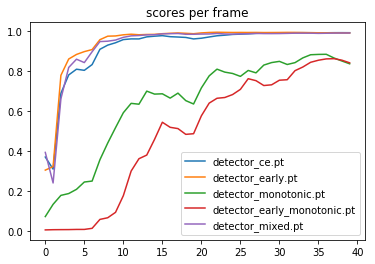

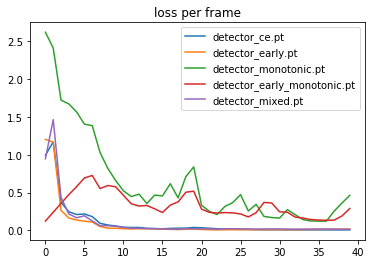

In [27]:
plt.figure(1)
plt.title('scores per frame')
for i,loss_type in enumerate(loss_types):
    plt.plot(scores_per_frame[i], label=GetModelName(loss_type))
    
plt.legend()
plt.show()

plt.figure(2)
plt.title('loss per frame')
for i,loss_type in enumerate(loss_types):
    plt.plot(loss_arrs_per_frame[i], label=GetModelName(loss_type))
    
plt.legend()
plt.show()

In [13]:
def inference_iteration(detector, input_variable):
    detector_hidden = detector.initHidden()
    detector_hidden = detector_hidden.cuda() if use_cuda else detector_hidden
    
    detector_cells = detector.initHidden()
    detector_cells = detector_cells.cuda() if use_cuda else detector_cells
    
    input_len = input_variable.shape[0]
    categories_per_frame = []
    scores_per_frame = []
    
    for di in range(input_len):
        #input len 500
        detector_input = np.array(input_variable[di,:]) #1x500
        detector_input = Variable(torch.FloatTensor(detector_input)).view(1,1,-1)
        detector_input = detector_input.cuda() if use_cuda else detector_input
        #
        detector_output, (detector_hidden, detector_cells) = detector(detector_input, (detector_hidden, detector_cells))
        topv, topi= softmax(detector_output).data.topk(5)
        ni = topi[0][0] #category id
        nv = topv[0][0] #score
        categories_per_frame.append(ni)
        scores_per_frame.append(nv)
            
    return np.array(categories_per_frame), np.array(scores_per_frame) #nframesx1 each

In [14]:
def inference(model_name, train_id_num):
    print("inference called with model_name: ", model_name)
    all_categories = []
    all_scores = []
    all_categories_true = []
    #model = torch.load(model_name)
    model = Detector(hidden_size, input_size, output_size, 0)
    model.load_state_dict(torch.load(model_name))
    model = model.cuda() if use_cuda else model
    model.lstm.flatten_parameters()
    max_train_video_len = 0
    binary_success = []
    for i,train_id in enumerate(train_ids):
        for seq in range(len(train_id_to_features[train_id])):
            input_variable = train_id_to_features[train_id][seq];
            categories, scores = inference_iteration(model, input_variable)
            if (max_train_video_len < input_variable.shape[0]):
                max_train_video_len = input_variable.shape[0]
            all_categories.append(categories)
            all_scores.append(scores)
            all_categories_true.append(train_id_to_categories[train_id][seq])
            binary_success.append((categories == np.array(train_id_to_categories[train_id][seq])).astype(int))
        if (i >= train_id_num):
            break

    return binary_success

In [15]:
def CropAndPad(input_res, crop_frame):
    for i in range(len(input_res)):
        #remove the first one, since its non activity
        input_res[i] = input_res[i][1:input_res[i].shape[0]];
    
        if (input_res[i].shape[0] > crop_frame):
            input_res[i] = input_res[i][0:crop_frame]
        else:
            pad_size = crop_frame - input_res[i].shape[0]
            input_res[i] = np.pad(input_res[i], (0, pad_size), 'edge')
        if (input_res[i].shape[0] != crop_frame):
            print(input_res[i].shape[0])
        
    return input_res

In [24]:
loss_types = [LossFuncType.CE, LossFuncType.EARLY, LossFuncType.MONOTONIC, LossFuncType.EARLY_MONOTONIC]
average_accuracy_per_frame = []
for i,loss_type in enumerate(loss_types):
    binary_classify_success = inference(GetModelName(loss_type), val_id_num)
    binary_classify_success = CropAndPad(binary_classify_success, crop_frame=20)
    average_accuracy_per_frame.append(sum(binary_classify_success)/len(binary_classify_success))

inference called with model_name:  detector_ce.pt


/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


inference called with model_name:  detector_early.pt


/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


inference called with model_name:  detector_monotonic.pt


/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


inference called with model_name:  detector_early_monotonic.pt


/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


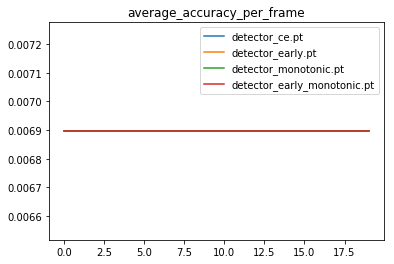

In [25]:
plt.figure(3)
plt.title('average_accuracy_per_frame')
for i,loss_type in enumerate(loss_types):
    plt.plot(average_accuracy_per_frame[i], label=GetModelName(loss_type))
    
plt.legend()
plt.show()